## Install the packages

In [1]:
!pip install git+https://github.com/cleanlab/cleanlab.git
!pip install cleanlab
!pip install 'cleanlab[DataLab]'
!pip install skorch

  Cloning https://github.com/cleanlab/cleanlab.git to /tmp/pip-req-build-mblh0vqs
  Running command git clone --filter=blob:none --quiet https://github.com/cleanlab/cleanlab.git /tmp/pip-req-build-mblh0vqs
  Resolved https://github.com/cleanlab/cleanlab.git to commit 21b82a325e7828d25292c25c121b908075ab7204
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cleanlab: filename=cleanlab-2.4.1-py3-none-any.whl size=283245 sha256=5be1e5ad9baf25e6012f9e79f7d24296e316cd9e5384f5f1fc12c06a74f9d891
  Stored in directory: /tmp/pip-ephem-wheel-cache-_amnvxlh/wheels/3d/53/8f/09fde0499e2135d2566a50fe7afd0398373244187206c7d441
Successfully built cleanlab
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.3 MB/s eta 0:00:00
    

## Import Libraries

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import warnings
import math

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

## **CIFAR-10**

Fetching the dataset

In [21]:
cifar = fetch_openml("CIFAR_10")

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [22]:
cifar.data.shape

(60000, 3072)

Reshaping the images

In [23]:
X = cifar.data.astype("float32").to_numpy()
X = X / 255.0
X = X.reshape(len(X), 3, 32, 32)

y = cifar.target.astype("int64")

In [24]:
X.shape

(60000, 3, 32, 32)

Visualizing an image

Data : 


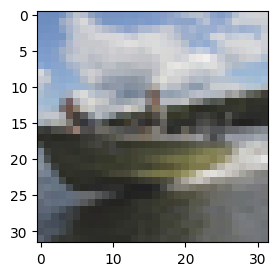

The target label is:  ship


In [25]:
plt.figure(figsize = (3,3))
idx = 6
grid_data = X[idx].transpose(1,2,0)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']
print("Data : ")
plt.imshow(grid_data)
plt.show()

print("The target label is: ", class_labels[y[idx]])

PyTorch model

In [26]:
from torch import nn

class cifar_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),

        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

Ensuring that the model is scikit-learn compatible

In [27]:
from skorch import NeuralNetClassifier

model_skorch = NeuralNetClassifier(cifar_model)

In [28]:
from sklearn.model_selection import cross_val_predict
num_crossval_folds = 5
pred_probs = cross_val_predict(
    model_skorch,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.4353       0.4893        1.4733  73.6237
      2        0.9937       0.6082        1.0958  74.2261
      3        0.7780       0.6701        0.9405  74.5086
      4        0.6144       0.6714        0.9558  74.2917
      5        0.4668       0.6928        0.8997  74.5433
      6        0.3242       0.7142        0.8543  74.2769
      7        0.1939       0.6775        1.0542  74.2971
      8        0.0986       0.7094        0.9609  73.6730
      9        0.0485       0.7303        0.9213  74.4063
     10        0.0270       0.7434        0.8717  73.1462
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.4244       0.5797        1.1899  73.8784
      2        0.9909       0.6302        1.0483  74.4072
      3        0.7728       0.6806        0.9169  74.8834
      4       

In [11]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)
print(f"Cross-validated estimate of accuracy: %.2f%%"%(acc*100))

Cross-validated estimate of accuracy: 75.54%


airplane


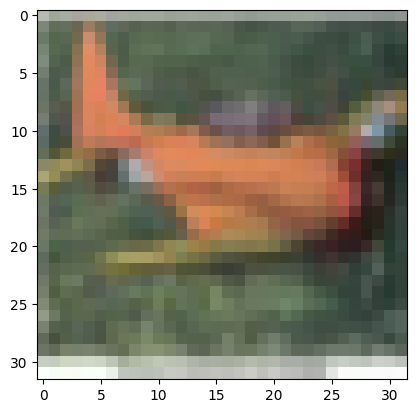

In [12]:
idx = 2
img = X[idx].transpose(1,2,0)
plt.imshow(img)
print(class_labels[y[idx]])

In [13]:
from cleanlab import Datalab

data = {"X": X, "label": y}

In [14]:
lab = Datalab(data, label_name="label")
lab.find_issues(pred_probs=pred_probs, issue_types={"label":{}})

Finding label issues ...

Audit complete. 9853 issues found in the dataset.


In [15]:
issue_results = lab.get_issues("label")
issue_true = issue_results[issue_results['is_label_issue'] == True]

In [16]:
issue_true

,is_label_issue,label_score,given_label,predicted_label
2,True,0.000721,0,4
18,True,0.194822,7,4
19,True,0.176048,2,3
30,True,0.133710,7,5
45,True,0.089508,0,2
...,...,...,...,...
59981,True,0.068309,4,7
59982,True,0.000355,2,6
59986,True,0.059005,8,0
59993,True,0.002601,5,3


In [17]:
import math

[5274, 5282, 5395, 5455, 5488, 5744, 5754, 5803, 6051, 6098, 6146, 6287, 6549, 6629, 6660, 6663, 6891, 6926, 6981, 7081]
20


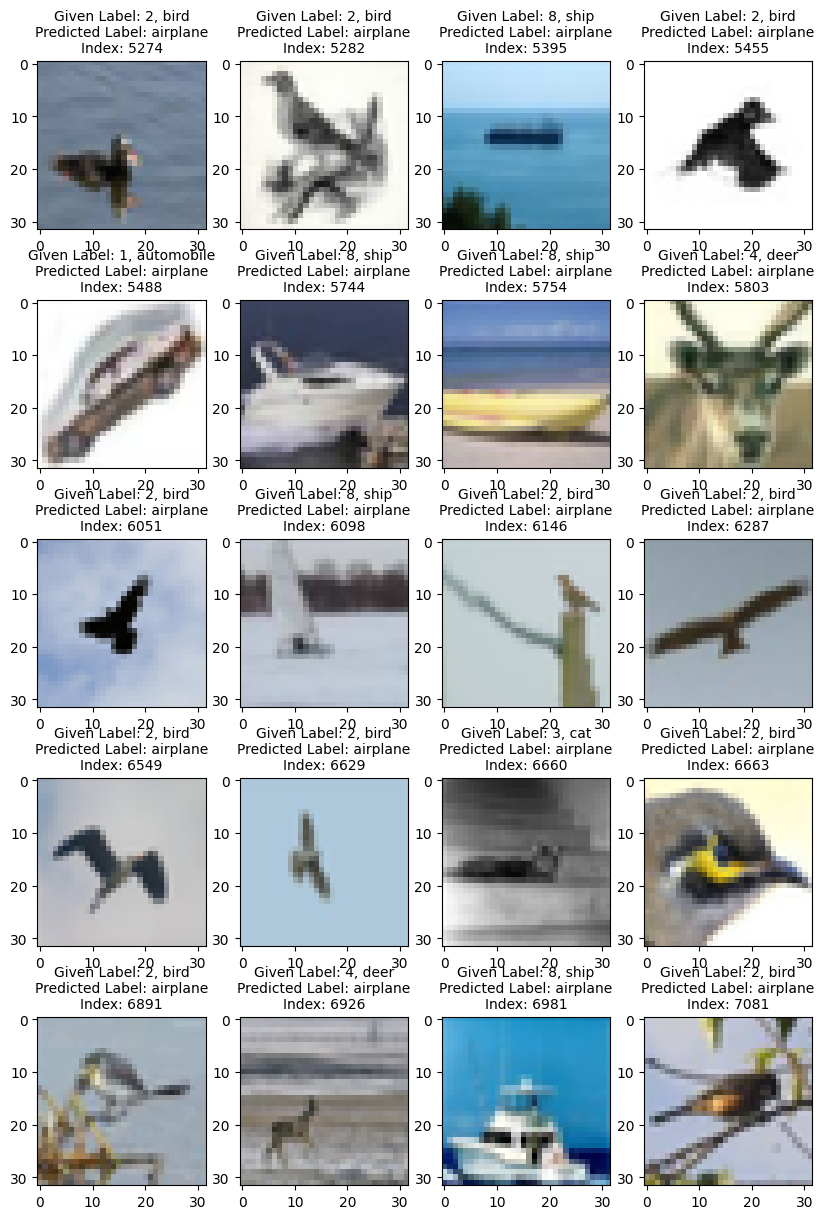

In [18]:
classes = 0
locations = []
for i in range(0, len(issue_true)):
  loc = issue_true.iloc[i].predicted_label
  if(loc == classes):
    locations.append(issue_true.index[i])

locations = locations[60:80]
print(locations)
print(len(locations))
rows = math.ceil(len(locations)/4)

if(rows>1):
  count = 0
  fig, axs = plt.subplots(nrows = rows, ncols = 4, figsize=(10, 15))
  for r in range(rows):
    for c in range(4):
      if(count<len(locations)):
        l = locations[count]
        axs[r][c].imshow(X[l].transpose(1,2,0))
        axs[r][c].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+", "+str(class_labels[issue_results.iloc[l].given_label])+"\nPredicted Label: "+str(class_labels[issue_results.iloc[l].predicted_label])+"\nIndex: "+str(l), fontsize='medium')
        count += 1
      else:
        fig.delaxes(axs[r][c])
else:
  count = 0
  fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(10, 15))
  for i in range(4):
    if(count < len(locations)):
      l = locations[count]
      axs[i].imshow(X[l].transpose(1,2,0))
      axs[i].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+"\nPredicted Label: "+str(issue_results.iloc[l].predicted_label)+"\nIndex: "+str(l), fontsize='medium')
      count += 1
    else:
      fig.delaxes(axs[i])


automobile


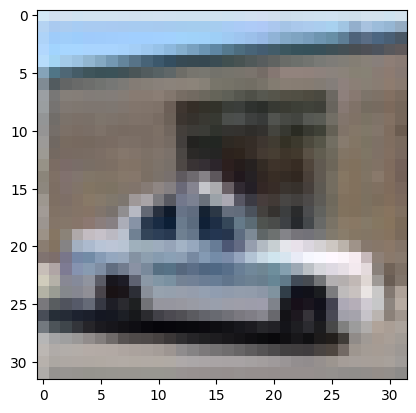

In [19]:
idx = 36710
img = X[idx].transpose(1,2,0)
plt.imshow(img)
print(class_labels[y[idx]])

In [ ]:
y[[52405, 52226]] = 6
y[[52804, 57002]] = 5

In [ ]:
#delete = 21347

In [ ]:
X_updated = np.delete(X, [21347], axis=0)
X_updated.shape

(59999, 3, 32, 32)

In [ ]:
y_updated = np.delete(y.to_numpy(), [21347])
y_updated.shape

(59999,)

In [ ]:
num_crossval_folds = 5  # for efficiency; values like 5 or 10 will generally work better
pred_probs = cross_val_predict(
    model_skorch,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.4376       0.4877        1.4257  73.6017
      2        0.9845       0.5878        1.1371  73.7571
      3        0.7643       0.6478        0.9864  73.8722
      4        0.6003       0.6850        0.8822  73.2840
      5        0.4531       0.7143        0.8191  74.3731
      6        0.3114       0.6994        0.8993  73.0893
      7        0.1835       0.7334        0.8160  73.5520
      8        0.0923       0.7370        0.8529  73.3693
      9        0.0461       0.7418        0.8630  73.3719
     10        0.0259       0.7461        0.8737  73.3867
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.4193       0.5828        1.1928  73.3792
      2        0.9854       0.6613        0.9767  73.5126
      3        0.7630       0.6924        0.8828  73.6077
      4       

In [ ]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: %.2f%%"%(acc*100))

Cross-validated estimate of accuracy on held-out data: 74.88%


**Security-related issue**

Delibrately changing some labels

In [ ]:
y[[480, 650, 547, 222, 346, 388, 979, 675, 789, 1111, 1323]] = 0
y[[943, 545, 723, 1444, 1832]] = 1
y[[1943, 3333, 221, 101]] = 5

In [ ]:
data = {"X": X, "label": y}

In [ ]:
lab = Datalab(data, label_name="label")
lab.find_issues(pred_probs=pred_probs, issue_types={"label":{}})

Finding label issues ...

Audit complete. 3082 issues found in the dataset.


In [ ]:
issue_results = lab.get_issues("label")
issue_true = issue_results[issue_results['is_label_issue'] == True]

Label IDs :  [221, 1943, 3333, 15392, 19928, 22504, 26270, 26790, 27550, 30151, 34959, 39262, 39872, 40628, 41163, 44779, 46360, 51747, 53488, 60722, 64405, 68532]
No. of wrong labels :  22


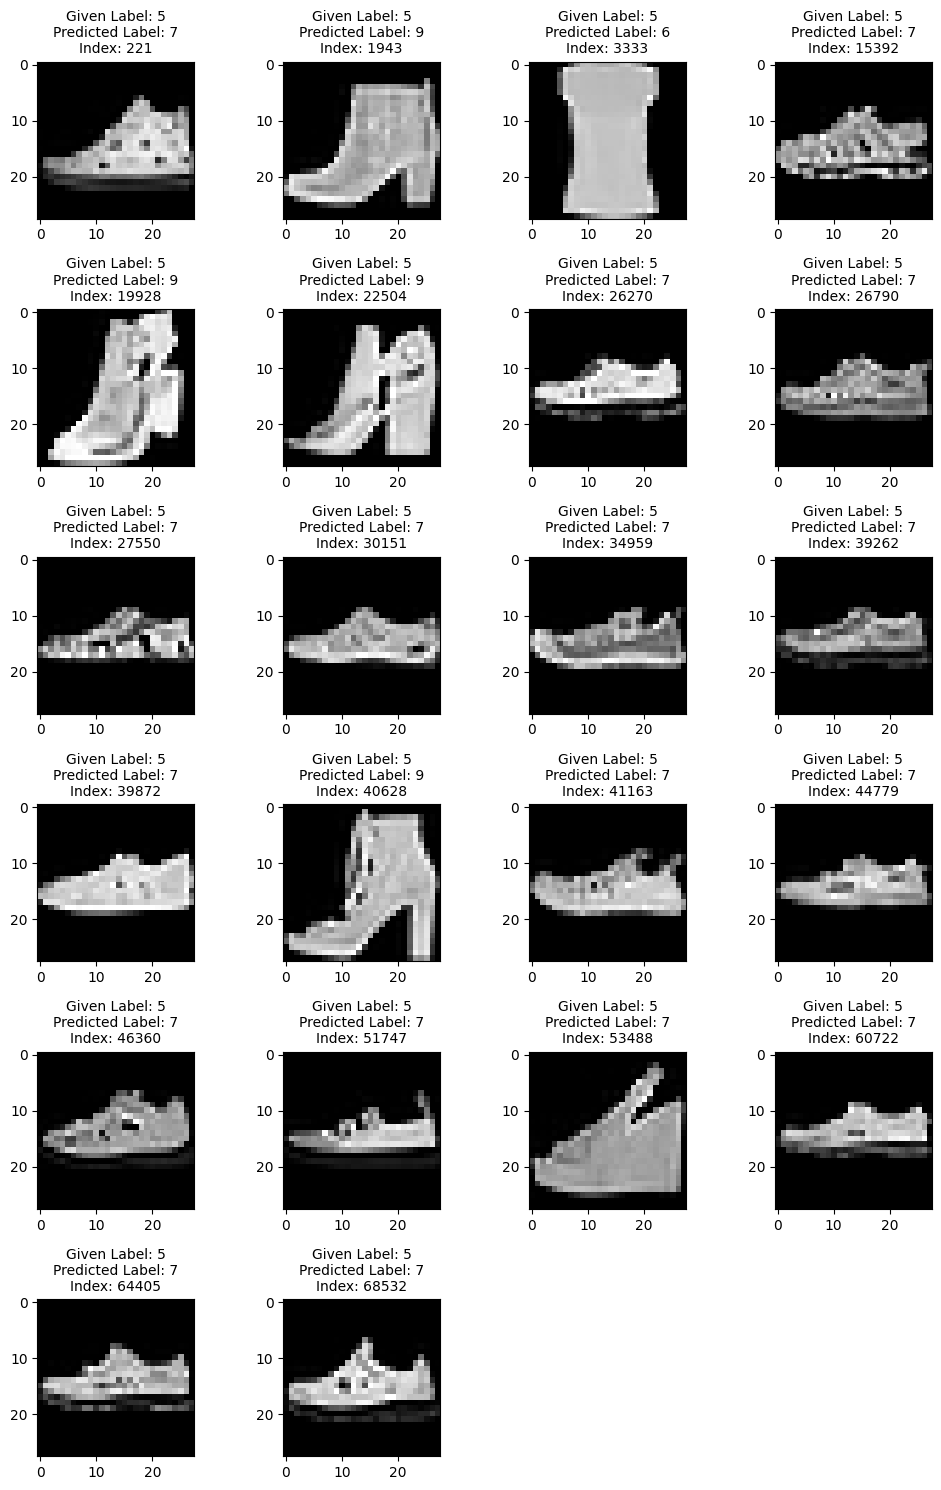

In [ ]:
classes = 0
locations = []
for i in range(0, len(issue_true)):
  loc = issue_true.iloc[i].predicted_label
  if(loc == classes):
    locations.append(issue_true.index[i])

locations = locations[0:15]
print(locations)
print(len(locations))
rows = math.ceil(len(locations)/4)

if(rows>1):
  count = 0
  fig, axs = plt.subplots(nrows = rows, ncols = 4, figsize=(10, 15))
  for r in range(rows):
    for c in range(4):
      if(count<len(locations)):
        l = locations[count]
        axs[r][c].imshow(X[l].transpose(1,2,0))
        axs[r][c].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+", "+str(class_labels[issue_results.iloc[l].given_label])+"\nPredicted Label: "+str(class_labels[issue_results.iloc[l].predicted_label])+"\nIndex: "+str(l), fontsize='medium')
        count += 1
      else:
        fig.delaxes(axs[r][c])
else:
  count = 0
  fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(10, 15))
  for i in range(4):
    if(count < len(locations)):
      l = locations[count]
      axs[i].imshow(X[l].transpose(1,2,0))
      axs[i].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+"\nPredicted Label: "+str(issue_results.iloc[l].predicted_label)+"\nIndex: "+str(l), fontsize='medium')
      count += 1
    else:
      fig.delaxes(axs[i])
